In [1]:
# Install a pip package in the current Jupyter kernel
import sys
import os
sys.path.append('../')
sys.path.append('../corv/src')


### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import astropy
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join

from tqdm import tqdm
import pandas as pd
from scipy.optimize import curve_fit
import scipy.stats as stats

### Tools
import WD_models
from bisect import bisect_left
import lmfit
import glob

from astroquery.sdss import SDSS
from astroquery.gaia import Gaia

#corv.sdss.make_catalogs()

In [2]:
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

In [3]:
from __future__ import print_function
from astropy.coordinates import SkyCoord
import astropy.units as u

In [4]:
from astropy.table import Table, vstack, unique

ms_sdss4_wd_sdss4 = Table.read('data/ms_sdss4_wd_sdss4.fits')
ms_gaia_wd_sdss4 = Table.read('data/ms_gaia_wd_sdss4.fits')
ms_sdss5_wd_sdss4 = Table.read('sdss5/ms_sdss5_wd_sdss4.fits')

ms_gaia_wd_sdss5 = Table.read('sdss5/ms_gaia_wd_sdss5.fits')
ms_sdss4_wd_sdss5 = Table.read('sdss5/ms_sdss4_wd_sdss5.fits')
ms_sdss5_wd_sdss5 = Table.read('sdss5/ms_sdss5_wd_sdss5.fits')

ms_gaia_wd_falcon = Table.read('data/ms_gaia_wd_falcon.fits')
gemini = Table.read('data/gemini.fits')


def strip(catalog):  
    drop_cols = []
    keep_cols = ['wd_source_id', 'ms_source_id', 'wd_l', 'wd_b', 'ms_parallax', 'ms_parallax_over_error', 'wd_ra', 'wd_dec', 
                 'wd_bp_rp', 'uses_sdss5']
        
    for key in catalog.keys():
        if key not in keep_cols:
            drop_cols.append(key)
            
    catalog.remove_columns(drop_cols)
    
    return catalog

ms_gaia_wd_sdss4  = strip(ms_gaia_wd_sdss4 )
ms_sdss4_wd_sdss4 = strip(ms_sdss4_wd_sdss4)
ms_sdss5_wd_sdss4 = strip(ms_sdss5_wd_sdss4)

ms_gaia_wd_sdss5  = strip(ms_gaia_wd_sdss5 )
ms_sdss4_wd_sdss5 = strip(ms_sdss4_wd_sdss5)
ms_sdss5_wd_sdss5 = strip(ms_sdss5_wd_sdss5)

gemini_1 = gemini.copy()

ms_gaia_wd_falcon = strip(ms_gaia_wd_falcon)
gemini = strip(gemini)

catalog = unique(vstack([ms_sdss4_wd_sdss4, ms_gaia_wd_sdss4, ms_sdss4_wd_sdss5, ms_sdss5_wd_sdss4, ms_gaia_wd_sdss5, ms_sdss5_wd_sdss5, ms_gaia_wd_falcon, gemini]), keys = 'wd_source_id')

In [5]:
print(catalog)

    ms_source_id        wd_source_id    ...         wd_b        uses_sdss5
------------------- ------------------- ... ------------------- ----------
  78630547564037504   78630783787018624 ...  -43.94621045934461        0.0
  90243761175084672   90244375354955392 ...  -44.60031645677885        0.0
  91690164426524288   91690164426711040 ... -42.932042516885794        0.0
 235840678609579904  235840781689958016 ... -15.142418794667933        0.0
 290678443086494848  290678477446232960 ...  -37.92124428204657        0.0
 299817274499164416  299817270203790464 ... -31.650726348757026        0.0
 300721519733864192  300721515441972608 ... -31.261650914977317        1.0
 361278462663417088  361278458368372992 ... -29.894258797869995        0.0
 520790043347308416  520790043346964608 ...    7.43745748400846        1.0
 545940409758573824  545940164944375296 ...  11.629824001353866        1.0
                ...                 ... ...                 ...        ...
6339275457204986496 63392

In [6]:
from astropy.table import Table, vstack, hstack

only_rvs = True

stardats = []
iters = (len(catalog)+100) // 100

# MS Gaia Sources

for i in tqdm(range(iters)):
        ADQL_CODE1 = """SELECT dist.source_id, dist.r_med_geo
        FROM gaiadr3.gaia_source as gaia
        JOIN external.gaiaedr3_distance as dist
        ON gaia.source_id = dist.source_id      
        WHERE gaia.source_id in {}""".format(tuple(catalog['ms_source_id'][100*i:100*i+100]))
        stardats.append(Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results())
        
gaia_d1 = vstack(stardats)
gaia_d1.rename_column('source_id', 'ms_source_id')
catalog = join(catalog, gaia_d1, keys = 'ms_source_id')

100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


In [7]:
catalog.remove_column('ms_source_id')

In [8]:
stardats = []
iters = (len(catalog)+100) // 100

# This query is for making sure the radii issue isn't a problem with the photometry from the El-Badry catalog (it's not)
for i in tqdm(range(iters)):
        ADQL_CODE1 = """SELECT source_id, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, phot_g_mean_flux, phot_bp_mean_flux, phot_rp_mean_flux,
                 phot_g_mean_flux_error, phot_bp_mean_flux_error, phot_rp_mean_flux_error
        FROM gaiadr3.gaia_source     
        WHERE source_id in {}""".format(tuple(catalog['wd_source_id'][100*i:100*i+100]))
        stardats.append(Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results())
        
gaia_d1 = vstack(stardats)

for key in gaia_d1.keys():
    gaia_d1.rename_column(key, 'wd_' + key)
    
catalog = join(catalog, gaia_d1, keys = 'wd_source_id')

100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


In [9]:
from __future__ import print_function
from astropy.coordinates import SkyCoord
import astropy.units as u
from dustmaps.edenhofer2023 import Edenhofer2023Query

import pyphot
import extinction

# Coordinates using Bailer-Jones distances
coords = [SkyCoord(frame="galactic", l=catalog['wd_l'][i]*u.deg, b=catalog['wd_b'][i]*u.deg, distance = catalog['r_med_geo'][i] * u.pc) for i in range(len(catalog))]
catalog['wd_coords'] = coords


# Query Edenhofer2023 to get E(B-V) in arbitrary units
bsq = Edenhofer2023Query()
bsq_res = bsq.query(catalog['wd_coords']).copy()
bsq_res[np.isnan(bsq_res)] = 0

# Convert to actual units
Ebv = bsq_res*0.901*0.98
e_Ebv = Ebv*0.2

catalog['E(B-V)'] = Ebv
catalog['e_E(B-V)'] = e_Ebv


# Parameters for correcting using Gaia
Rv = 3.1
catalog['A_v0'] = catalog['E(B-V)']*Rv

# Fetch Gaia photometric band wavelengths and store in `gaia_phot_wavl`
lib = pyphot.get_library()
gaia_phot = [lib['Gaia_BP'], lib['Gaia_RP']]
gaia_phot_wavl = np.array([x.lpivot.to('angstrom').value for x in gaia_phot])


# For each point, find extinction using the parameters we defined above
ext_all = []
for av0 in catalog['A_v0']:
    ext_all.append( extinction.fitzpatrick99(gaia_phot_wavl, av0, Rv) )
ext_all = np.array(ext_all)
    
# Save the extinction in each band
catalog['BP_ext'] = ext_all.T[0]
catalog['RP_ext'] = ext_all.T[1]

# Subtract out the extinction to find de-reddened magnitude
catalog['wd_phot_bp_mean_mag_ext'] = catalog['wd_phot_bp_mean_mag'] - catalog['BP_ext']
catalog['wd_phot_rp_mean_mag_ext'] = catalog['wd_phot_rp_mean_mag'] - catalog['RP_ext']

Optimizing map for querying (this might take a couple of seconds)...


In [10]:
i = 1

print(catalog['wd_phot_bp_mean_mag_ext'][i])
print(catalog['wd_phot_bp_mean_mag'][i])
print(catalog['BP_ext'][i])
print(catalog['wd_phot_bp_mean_mag'][i] - catalog['BP_ext'][i])

20.168963829533862
20.169289
0.0003248057200452759
20.168963829533862


In [11]:
#sigmaG_0 = 0.0027553202
#sigmaGBP_0 = 0.0027901700
#sigmaGRP_0 = 0.0037793818
#
#catalog['e_wd_phot_g_mean_mag'] = np.sqrt((-2.5/np.log(10)*catalog['wd_phot_g_mean_flux_error']/catalog['wd_phot_g_mean_flux'])**2 + sigmaG_0**2)
#catalog['e_wd_phot_bp_mean_mag'] = np.sqrt((-2.5/np.log(10)*catalog['wd_phot_bp_mean_flux_error']/catalog['wd_phot_bp_mean_flux'])**2 + sigmaGBP_0**2)
#catalog['e_wd_phot_rp_mean_mag'] = np.sqrt((-2.5/np.log(10)*catalog['wd_phot_rp_mean_flux_error']/catalog['wd_phot_rp_mean_flux'])**2 + sigmaGRP_0**2)

In [12]:
font_model = WD_models.load_model('f', 'f', 'f', 'H', HR_bands = ['Su-Sg', 'Su'])

g_acc = (10**font_model['logg'])/100
rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
logg_teff_to_rsun = WD_models.interp_xy_z_func(x = font_model['logg'], y = 10**font_model['logteff'],
                                            z = rsun, interp_type = 'linear')

fitsed_sdss = WD_models.FitSED(to_flux = False, atm_type = 'H', bands = ['Su', 'Sg', 'Sr'])#, 'Si', 'Sz'])
fitsed_gaia = WD_models.FitSED(to_flux = False, atm_type = 'H', bands = ['bp', 'rp'])#, 'Si', 'Sz'])

initialized with atm_type = H and bands = ['Su', 'Sg', 'Sr']
initialized with atm_type = H and bands = ['bp', 'rp']


In [13]:
from scipy.interpolate import RegularGridInterpolator

# Band selector: 
#    to fit with G, BP, RP, set `bands = ['g', 'bp', 'rp']`.
#    to fit with only BP, RP, set `bands = ['bp', 'rp']`

bands = ['bp', 'rp']

#test = Table.read('../WD_models/Montreal_atm_grid_2021/Table_DA', format='ascii')
#
#if len(bands) == 3:
#    test['mag'] = np.array([test['G3'], test['G3_BP'], test['G3_RP']]).T
#elif len(bands) == 2:
#    test['mag'] = np.array([test['G3_BP'], test['G3_RP']]).T
#
#for key in test.keys():
#    if key not in ['Teff', 'logg', 'mag']:
#        test.remove_column(key)
#    
#teffs = sorted(list(set(test['Teff'])))
#loggs = sorted(list(set(test['logg'])))
#
#if len(bands) == 3:
#    values = np.zeros((len(teffs), len(loggs), 3))
#elif len(bands) == 2:
#    values = np.zeros((len(teffs), len(loggs), 2))
#
#for i in tqdm(range(len(teffs))):
#    for j in range(len(loggs)):
#        try:
#            values[i,j] = test[np.all([test['Teff'] == teffs[i], test['logg'] == loggs[j]], axis = 0)]['mag'][0]
#        except:
#            if len(bands) == 3:
#                values[i,j] = np.array([0, 0, 0])
#            elif len(bands) == 2:
#                values[i,j] = np.array([0, 0])
#            
#model_sed = RegularGridInterpolator((teffs, loggs), values)

building montreal da model
could not find pickled WD models
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.
2691
2691


Text(0, 0.5, 'Flux $[erg/s/cm^2/\\AA]$')

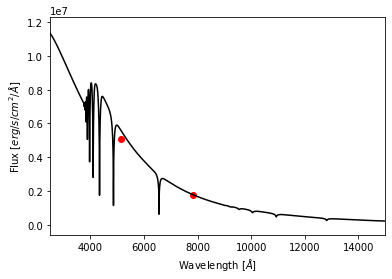

In [14]:
import pyphot
from pyphot import unit

import corv

base_wavl, tremblay, table = corv.utils.build_montreal_da(path = '/home/sarsene1/corv/src/corv/models/montreal_da', flux_unit = 'flam')

print(len(base_wavl))

lib = pyphot.get_library()
filters = [lib['Gaia_BP'], lib['Gaia_RP']]

fl = tremblay((10000, 8))
print(len(fl))

wavl = [filters[i].lpivot.to('angstrom').value for i in range(len(filters))]
phot_flux = [filters[i].get_flux(base_wavl * unit['AA'], fl * unit['erg/s/cm**2/AA'], axis = 1).value for i in range(len(filters))]
phot_mag = np.array([-2.5*np.log10(filters[i].get_flux(base_wavl * unit['AA'], fl * unit['erg/s/cm**2/AA'], axis = 1).value) \
                     - filters[i].Vega_zero_mag for i in range(len(filters))])

plt.plot(base_wavl, fl, c = 'k')
plt.scatter(wavl, phot_flux, c = 'r')
plt.xlim(2500,15000)
plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Flux $[erg/s/cm^2/\AA]$')


In [15]:
import pyphot
from pyphot import unit

base_wavl, tremblay, table = corv.utils.build_montreal_da(path = '/home/sarsene1/corv/src/corv/models/montreal_da', flux_unit = 'flam')

lib = pyphot.get_library()
filters = [#lib['Gaia_G'],
           lib['Gaia_BP'], lib['Gaia_RP']]


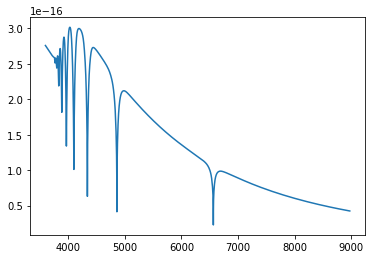

In [16]:
radius = 0.015*radius_sun
distance = 200*pc_to_m

fl = tremblay((10000, 8)) * 4 * np.pi * (radius / distance)**2

mask = (3600 < base_wavl)*(base_wavl<9000)

plt.plot(base_wavl[mask], fl[mask])

In [17]:
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16
radius_sun = 6.957e8

def mag_to_flux_spec(mag, filt, e_mag = None):
    if e_mag is not None:
        return (10**( (mag + filt.Vega_zero_mag) / -2.5 ), np.sqrt((-0.921034 * 10**(-0.4 * (mag + filt.Vega_zero_mag)) * e_mag)**2 ))
    else:
        return 10**( (mag + filt.Vega_zero_mag) / -2.5 )

def template(teff, logg, radius, distance):
    fl = tremblay((teff, logg))
    
    radius = radius * radius_sun # Rsun to meter
    distance = distance * pc_to_m # Parsec to meter
    
    fl = 4*np.pi*(radius / distance)**2 * fl
    return fl
    

def get_model_flux_gaia_spec(params):
    teff, logg, radius, distance = params['teff'], params['logg'], params['radius'], params['distance']
    
    fl = template(teff, logg, radius, distance) 
            
    flux = np.array([filters[i].get_flux(base_wavl * unit['angstrom'], fl * unit['erg/s/cm**2/angstrom'], axis = 1).to('erg/s/cm**2/angstrom').value for i in range(len(filters))])
    #mag = np.array([-2.5*np.log10(filters[i].get_flux(base_wavl * unit['AA'], fl * unit['erg/s/cm**2/AA'], axis = 1).value) - filters[i].Vega_zero_mag for i in range(len(filters))])
    return flux
    

def residual_gaia(params, obs_flux = None, e_obs_flux = None):
    model_flux = get_model_flux_gaia_spec(params)

    chisquare = ((model_flux - obs_flux) / e_obs_flux)**2
    
    #chisquare[np.isnan(chisquare)] = 1e8
    return chisquare



In [18]:
filters[0].Vega_zero_mag

20.97231143214712

In [19]:
print(catalog['wd_phot_bp_mean_mag_ext'][0])
print(catalog['wd_phot_bp_mean_mag'][0])
print(catalog['BP_ext'][0])
print(catalog['wd_phot_bp_mean_mag'][0] - catalog['BP_ext'][0])

20.168963829533862
20.169289
0.0003248057200452759
20.168963829533862


In [20]:
print(mag_to_flux_spec(catalog['wd_phot_bp_mean_mag'][0], filters[0]))
print(mag_to_flux_spec(catalog['wd_phot_bp_mean_mag_ext'][0] , filters[0]))
print(catalog['wd_phot_bp_mean_flux'][0] * 2.620707e-33 * 2.99792458e+21 / 5109.7**2)

3.494298268741833e-17
3.4953437693377193e-17
3.516818675423334e-17


In [21]:
def get_parameters_gaia(obs_flux, e_obs_flux, id_ = None, floor_error = 0.02, make_plot = False, vary_logg = False, p0 = [10000, 8, 0.01, 100]):         
    #e_obs_mag = np.sqrt(e_obs_mag**2 + floor_error**2)    
    params = lmfit.Parameters()

    params.add('teff', value = p0[0], min = 4001, max = 35000, vary = True)
    params.add('logg', value = p0[1], min=5, max=9, vary=False)
    params.add('radius', value = p0[2], min = 0.000001, max = 0.05, vary = True)
    params.add('distance', value = p0[3], min = 1, max = 2000, vary = False)
            
    #result = lmfit.minimize(residual_gaia, params, kws = dict(obs_flux = obs_mag, e_obs_flux = e_obs_mag), method = 'emcee', steps = 500, burn = 250, thin = 20, is_weighted = True, float_behavior = 'chi2', progress = False)
    result = lmfit.minimize(residual_gaia, params, kws = dict(obs_flux = obs_flux, e_obs_flux = e_obs_flux), method = 'leastsq')
    
    #result.params.pretty_print()
        
    return result

In [22]:
plt.style.use('stefan.mplstyle')

gaia_results = []
gaia_results7 = []
gaia_results9 = []

reference_results = []
reference_results7 = []
reference_results9 = []


e_results = []

drops = []

logg_vary = []

id_ = []

bands = ['bp', 'rp']

for i in tqdm(range(len(catalog))):
    # Convert Gaia flux into f_lam using table 5.3 
    # https://gea.esac.esa.int/archive/documentation/GEDR3/Data_processing/chap_cu5pho/cu5pho_sec_photProc/cu5pho_ssec_photCal.html    
    
    obs_flux_ext = np.array([mag_to_flux_spec(catalog['wd_phot_bp_mean_mag_ext'][i], filters[0]),
                         mag_to_flux_spec(catalog['wd_phot_rp_mean_mag_ext'][i], filters[1])])
    
    obs_flux = np.array([mag_to_flux_spec(catalog['wd_phot_bp_mean_mag'][i], filters[0]),
                         mag_to_flux_spec(catalog['wd_phot_rp_mean_mag'][i], filters[1])])
    e_obs_flux = np.array([#catalog['wd_phot_g_mean_flux_error'][i] * 1.736011e-33 * 2.99792458e+21 / 6217.9**2 , 
                           catalog['wd_phot_bp_mean_flux_error'][i] * 2.620707e-33 * 2.99792458e+21 / 5109.7**2, 
                           catalog['wd_phot_rp_mean_flux_error'][i] * 3.2988153e-33 * 2.99792458e+21 / 7769.1**2])
        
    #try:    
    gaia_logg7_ext = get_parameters_gaia( obs_flux_ext, e_obs_flux, vary_logg=False, p0 = [10000, 7, 0.003, catalog['r_med_geo'][i]] )
    gaia_logg8_ext = get_parameters_gaia( obs_flux_ext, e_obs_flux, vary_logg=False, p0 = [10000, 8, 0.003, catalog['r_med_geo'][i]] )
    gaia_logg9_ext = get_parameters_gaia( obs_flux_ext, e_obs_flux, vary_logg=False, p0 = [10000, 9, 0.003, catalog['r_med_geo'][i]] )
    id_.append(i)
    
    gaia_results.append(gaia_logg8_ext)
    gaia_results7.append(gaia_logg7_ext)
    gaia_results9.append(gaia_logg9_ext)
    #except:
    #    drops.append(i)
        
    
    #reference_results.append(get_parameters_gaia(obs_flux, e_obs_flux, vary_logg=False, p0 = [10000, 8, 0.003, catalog['r_med_geo'][i]]))
    #reference_results7.append(get_parameters_gaia(obs_flux, e_obs_flux, vary_logg=False, p0 = [10000, 7, 0.003, catalog['r_med_geo'][i]]))
    #reference_results9.append(get_parameters_gaia(obs_flux, e_obs_flux, vary_logg=False, p0 = [10000, 9, 0.003, catalog['r_med_geo'][i]]))

    
    fig = plt.figure(figsize = (8,7))
        
    #plt.errorbar([filters[j].lpivot.to('angstrom').value for j in range(len(filters))], obs_flux, yerr = e_obs_flux, linestyle = 'none', marker = 'None', color = 'k', capsize = 5, label = 'Observed SED', zorder = 10)
    #plt.plot([filters[j].lpivot.to('angstrom').value for j in range(len(filters))], get_model_flux_gaia(gaia_logg8.params), 'bo', markersize = 10, label = 'Model SED')
    
    plt.errorbar([filters[j].lpivot.to('angstrom').value for j in range(len(filters))], obs_flux_ext, yerr = e_obs_flux, linestyle = 'none', marker = 'None', color = 'k', capsize = 5, label = 'Observed SED', zorder = 10)
    plt.plot([filters[j].lpivot.to('angstrom').value for j in range(len(filters))], get_model_flux_gaia_spec(gaia_logg8_ext.params), 'bo', markersize = 10, label = 'Model SED')
    
    model_fl = template(gaia_logg8_ext.params['teff'].value, gaia_logg8_ext.params['logg'].value, gaia_logg8_ext.params['radius'].value, gaia_logg8_ext.params['distance'].value)
    mask = (3600 < base_wavl)*(base_wavl<9000)
    plt.plot(base_wavl[mask], model_fl[mask], c = 'k', label = 'Model Spectrum')
    
    
    #model_fl = template(gaia_logg8.params['teff'].value, gaia_logg8.params['logg'].value, gaia_logg8.params['radius'].value, gaia_logg8.params['distance'].value)
    #mask = (3600 < base_wavl)*(base_wavl<9000)
    #plt.plot(base_wavl[mask], model_fl[mask], c = 'k', label = 'Model Spectrum')
    
    #plt.ylim(0.1*min(model_fl[mask]), 1.1*max(model_fl[mask]))
    
    #plt.title('SED {}'.format(i))
    
    plt.text(0.05, 0.20, "$T_{eff}$" + " = {:2.6} $K$".format(gaia_logg8_ext.params['teff'].value), transform = plt.gca().transAxes, fontsize = 18)
    plt.text(0.05, 0.15, "$\log g$" + " = {:2.5f}".format(gaia_logg8_ext.params['logg'].value), transform = plt.gca().transAxes, fontsize = 18)
    plt.text(0.05, 0.05, '$Distance = ${:2.1f} $pc$'.format(gaia_logg8_ext.params['distance'].value), transform = plt.gca().transAxes, fontsize=18)
    plt.text(0.05, 0.10, r'$Radius = ${:2.5f} $R_\odot$'.format(gaia_logg8_ext.params['radius'].value), transform = plt.gca().transAxes, fontsize = 18)
    plt.text(0.80, 0.05, r'$\chi_r^2 = ${:2.2f}'.format(gaia_logg8_ext.redchi), transform = plt.gca().transAxes, fontsize = 18)
    
    plt.xlim((3600, 9000))
    plt.xlabel(r'Wavelength $[\AA]$')
    plt.ylabel('Flux $[erg/s/cm^2/\AA]$')
        
    
    #plt.gca().invert_yaxis()
    plt.legend(framealpha = 0) 
    plt.savefig('spectra/leastsq/phot_fit/{}.png'.format(i))
    plt.close()
    
    #print(gaia_logg8.params['radius'].stderr)
    
    #fig = plt.figure(figsize = (8,7))
    
    #plt.errorbar([filters[j].lpivot.to('angstrom').value for j in range(len(filters))], obs_flux, yerr = e_obs_flux, linestyle = 'none', marker = 'None', color = 'k', capsize = 5, label = 'Observed SED', zorder = 10)
    #model_mag = get_model_flux_gaia(gaia_logg8.params)
    #plt.plot([filters[j].lpivot.to('angstrom').value for j in range(len(filters))], [mag_to_flux_spec(model_mag[i], filters[i]) for i in range(len(filters))], 'bo', markersize = 10, label = 'Model SED (Color Tables)')
    
    
    
    #plt.xlim((3600, 9000))
    #plt.xlabel(r'Wavelength $[\AA]$')
    #plt.ylabel('Flux $[erg/s/cm^2/\AA]$')
    
    #plt.legend(framealpha = 0) 
    #plt.show()
    
print('dropped {} stars'.format(len(drops)))
catalog.remove_rows(drops)
catalog['wd_catalog_id_phot'] = id_
results = gaia_results

100%|██████████| 613/613 [20:30<00:00,  2.01s/it]

dropped 0 stars


In [23]:
len(results)

613

In [24]:
np.isnan(results[0].params['radius'].stderr)

False

In [25]:
n = []

for result in results:
    try:
        np.isnan(result.params['radius'].stderr)
        n.append(1)
    except:
        result.params['radius'].stderr = 0
        n.append(0)

In [26]:
results[6]

In [27]:
catalog['raw_radius_result'] = [result for result in gaia_results]
catalog['radius'] = [result.params['radius'].value for result in gaia_results]
catalog['phot_teff'] = [result.params['teff'].value for result in gaia_results]
catalog['e_phot_teff'] = [result.params['teff'].stderr for result in gaia_results]
catalog['redchi'] = [result.redchi for result in gaia_results]
catalog['e_radius'] = [np.sqrt(gaia_results[i].params['radius'].stderr**2 + np.abs(gaia_results7[i].params['radius'].value - gaia_results9[i].params['radius'].value)**2 ) for i in range(len(gaia_results))]
catalog['error_from_model'] = [np.abs(gaia_results7[i].params['radius'].value - gaia_results9[i].params['radius'].value) for i in range(len(gaia_results))]

#catalog['undereddened_raw_radius_result'] = [result for result in reference_results]
#catalog['undereddened_radius'] = [result.params['radius'].value for result in reference_results]
#catalog['undereddened_phot_teff'] = [result.params['teff'].value for result in reference_results]
#catalog['undereddened_e_phot_teff'] = [result.params['teff'].stderr for result in reference_results]
#catalog['undereddened_redchi'] = [result.redchi for result in reference_results]
#catalog['undereddened_e_radius'] = [np.sqrt(reference_results[i].params['radius'].stderr**2 + np.abs(reference_results7[i].params['radius'].value - reference_results9[i].params['radius'].value)**2 ) for i in range(len(reference_results))]
#catalog['undereddened_error_from_model'] = [np.abs(reference_results7[i].params['radius'].value - reference_results9[i].params['radius'].value) for i in range(len(reference_results))]

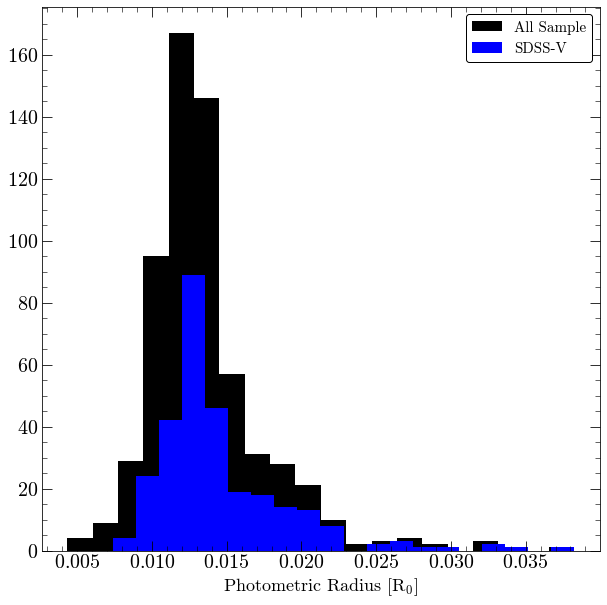

In [28]:
plt.figure(figsize=(10,10))
plt.hist(catalog['radius'], bins = 20, color='black', label = 'All Sample')
plt.hist(catalog['radius'][catalog['uses_sdss5'] == 1], bins = 20, color='blue', label = 'SDSS-V')
ymin, ymax = plt.ylim()
#plt.vlines(np.mean(catalog['phot_teff']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Photometric Radius $[R_0]$', fontsize=18)
plt.legend()

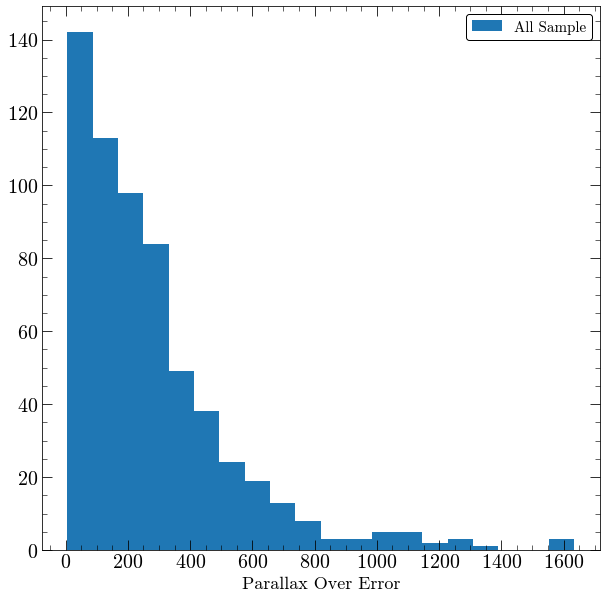

In [29]:
plt.figure(figsize=(10,10))
plt.hist(catalog['ms_parallax_over_error'], bins = 20, label = 'All Sample')
ymin, ymax = plt.ylim()
#plt.vlines(np.mean(catalog['phot_teff']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Parallax Over Error', fontsize=18)
plt.legend()

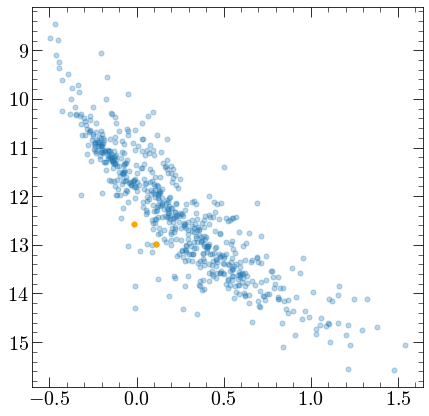

In [30]:
plt.scatter(catalog['wd_bp_rp'], catalog['wd_phot_g_mean_mag'] + 5 * np.log10(catalog['ms_parallax'] / 100), alpha = 0.3) 
plt.scatter(gemini_1['wd_bp_rp'], 
            gemini_1['wd_phot_g_mean_mag'] + 5 * np.log10(gemini_1['ms_parallax'] / 100), color = 'orange') 
plt.gca().invert_yaxis()


In [31]:
# Gemini object no.1
catalog[catalog['wd_source_id'] == 649472245695986816]

wd_source_id,ms_parallax,ms_parallax_over_error,wd_bp_rp,wd_ra,wd_dec,wd_l,wd_b,uses_sdss5,r_med_geo,wd_phot_g_mean_mag,wd_phot_bp_mean_mag,wd_phot_rp_mean_mag,wd_phot_g_mean_flux,wd_phot_bp_mean_flux,wd_phot_rp_mean_flux,wd_phot_g_mean_flux_error,wd_phot_bp_mean_flux_error,wd_phot_rp_mean_flux_error,wd_coords,E(B-V),e_E(B-V),A_v0,BP_ext,RP_ext,wd_phot_bp_mean_mag_ext,wd_phot_rp_mean_mag_ext,wd_catalog_id_phot,raw_radius_result,radius,phot_teff,e_phot_teff,redchi,e_radius,error_from_model
,,,,,,,,,pc,mag,mag,mag,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,"deg,deg,pc",,,,,,mag,mag,,,,,,,,
int64,float64,float32,float32,float64,float64,float64,float64,float64,float32,float32,float32,float32,float64,float64,float64,float32,float32,float32,SkyCoord,float64,float64,float64,float64,float64,float64,float64,int64,object,float64,float64,float64,float64,float64,float64
649472245695986816,3.6371048817093548,147.60089,-0.4258461,124.52862678921322,12.198718747803403,211.4506716608107,24.680348199619047,0.0,272.27396,17.443571,17.31139,17.737236,1983.8939820597616,1625.0269335261644,637.1825870140078,1.7266134,10.066547,7.6994715,"211.4506716608107,24.680348199619047,272.2739562988281",7.118572710003064e-06,1.4237145420006129e-06,2.2067575401009497e-05,2.3829542278781468e-05,1.2641365463399643e-05,17.311366093553424,17.737223381583757,43,<lmfit.minimizer.MinimizerResult object at 0x1553f8a26100>,0.011092322713024412,31055.969023941092,6.092483577482017e-05,8.766056180664705e-22,0.0006874720025134944,0.0006874720025134944


In [32]:
# Gemini object no.2
catalog[catalog['wd_source_id'] == 2545590733671247744]

wd_source_id,ms_parallax,ms_parallax_over_error,wd_bp_rp,wd_ra,wd_dec,wd_l,wd_b,uses_sdss5,r_med_geo,wd_phot_g_mean_mag,wd_phot_bp_mean_mag,wd_phot_rp_mean_mag,wd_phot_g_mean_flux,wd_phot_bp_mean_flux,wd_phot_rp_mean_flux,wd_phot_g_mean_flux_error,wd_phot_bp_mean_flux_error,wd_phot_rp_mean_flux_error,wd_coords,E(B-V),e_E(B-V),A_v0,BP_ext,RP_ext,wd_phot_bp_mean_mag_ext,wd_phot_rp_mean_mag_ext,wd_catalog_id_phot,raw_radius_result,radius,phot_teff,e_phot_teff,redchi,e_radius,error_from_model
,,,,,,,,,pc,mag,mag,mag,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,"deg,deg,pc",,,,,,mag,mag,,,,,,,,
int64,float64,float32,float32,float64,float64,float64,float64,float64,float32,float32,float32,float32,float64,float64,float64,float32,float32,float32,SkyCoord,float64,float64,float64,float64,float64,float64,float64,int64,object,float64,float64,float64,float64,float64,float64
2545590733671247744,23.199085497459805,1042.9606,1.061594,3.8088304758852845,0.36770672359199663,103.899598555634,-61.159151503568495,1.0,43.000797,17.684444,18.09276,17.031166,1589.1658278112227,791.2484629439028,1220.9325128460353,1.7557471,11.562339,19.258112,"103.899598555634,-61.159151503568495,43.000797271728516",0.0,0.0,0.0,0.0,0.0,18.09276008605957,17.031166076660156,367,<lmfit.minimizer.MinimizerResult object at 0x1553dc4244c0>,0.013968000315651138,5122.058484946618,0.0005837135481692272,2.3442987844469074e-14,0.0006361505930100089,0.0006361505927755026


In [34]:
catalog.remove_columns(['ms_parallax', 'wd_l', 'wd_b', 'raw_radius_result', 'wd_bp_rp', 'wd_phot_g_mean_mag', 'e_phot_teff',
                        'wd_phot_bp_mean_mag', 'wd_phot_rp_mean_mag', 'wd_phot_g_mean_flux_error', 'wd_phot_bp_mean_flux_error', 'wd_phot_rp_mean_flux_error'])

In [35]:
catalog.write('data/02_photometry.fits', overwrite=True)

In [36]:
nug = catalog[['wd_source_id', 'phot_teff']]
nug.pprint()

nug.write('data/nugget.fits', overwrite = True)

    wd_source_id        phot_teff     
------------------- ------------------
  78630783787018624  7465.888560305636
  90244375354955392  9377.368368766085
  91690164426711040 16900.154829325962
 235840781689958016 16608.709964026144
 290678477446232960  8498.604434222598
 299817270203790464  8335.807522868876
 300721515441972608  7602.741036886742
 361278458368372992  6779.746448748594
 520790043346964608  13164.18266565889
 545940164944375296  7649.983900803036
                ...                ...
6339275452909996544  5813.746226074689
6431084300169300224 34133.015561572945
6886973535081311872  11731.17472925442
6898255177217741952 10306.839848978781
6898705800892401280 12779.016348546376
6899127085644261632 12993.933388998814
6899212229075129344 14308.469798577193
6908407066861225728  7825.873099031417
6910805342238827648   21663.1182248204
6915121784373453184  8904.665947592963
6915495141583341824 10275.079780276643
Length = 613 rows
